In [14]:
#Program 4-2-2
# Detecting Skewness in Data (Hands-on)
# Dataset: retail_sales_week4.csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Settings
# -----------------------------
DATA_PATH = "D:/datasets/dpp/retail_sales_week4.csv"

FOCUS_COLS = ["annual_income", "monthly_spend", "avg_basket_value", "marketing_spend"]
ID_COLS = ["customer_id", "store_id"]
TARGET_COL = "target_sales"

# Skewness thresholds (common practical rule-of-thumb)
MILD = 0.5
HIGH = 1.0
SEVERE = 2.0


In [16]:
# -----------------------------
# 1) Load dataset
# -----------------------------
df = pd.read_csv(DATA_PATH)

print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())



Loaded: D:/datasets/dpp/retail_sales_week4.csv
Shape: (1000, 16)

Columns: ['customer_id', 'store_id', 'age', 'annual_income', 'monthly_spend', 'discount_percentage', 'purchase_frequency', 'avg_basket_value', 'avg_transaction_value', 'days_since_last_purchase', 'online_visits', 'total_returns', 'loyalty_score', 'marketing_spend', 'energy_consumption_store', 'target_sales']


In [17]:
# -----------------------------
# 2) Minimal cleaning BEFORE skew diagnosis
#    (We do NOT transform here; we just fix obvious invalid entries so skew detection is meaningful.)
# -----------------------------
df_diag = df.copy()

# Treat annual_income <= 0 as missing (0 used as missing-code in this dataset)
if "annual_income" in df_diag.columns:
    df_diag.loc[df_diag["annual_income"] <= 0, "annual_income"] = np.nan

# Treat negative marketing_spend as missing (data-entry error in this dataset)
if "marketing_spend" in df_diag.columns:
    df_diag.loc[df_diag["marketing_spend"] < 0, "marketing_spend"] = np.nan

# We do NOT impute everywhere for diagnosis; but for plots we may fill to avoid dropna surprises.
# We'll handle missing per-feature via dropna as needed.

print("\nMissing % (focus cols) after minimal cleaning:")
print((df_diag[FOCUS_COLS].isna().mean() * 100).round(2))



Missing % (focus cols) after minimal cleaning:
annual_income       6.4
monthly_spend       0.0
avg_basket_value    0.0
marketing_spend     3.6
dtype: float64


In [ ]:
# -----------------------------
# 3) Helper functions
# -----------------------------
def interpret_skew(sk: float) -> str:
    """Interpret skewness magnitude (absolute)."""
    a = abs(sk)
    if a < MILD:
        return "≈ symmetric (no transform likely)"
    elif a < HIGH:
        return "mild skew (optional)"
    elif a < SEVERE:
        return "high skew (transform recommended)"
    else:
        return "severe skew (transform strongly recommended)"



In [18]:
def recommend_action(col: str, series: pd.Series) -> str:
    """
    Provide simple preprocessing recommendation for a numeric feature
    based on skew + presence of non-positive values.
    """
    s = series.dropna()
    if s.empty:
        return "insufficient data"

    sk = s.skew()

    has_nonpositive = (s <= 0).any()
    # (nonpositive matters for log)
    if abs(sk) < MILD:
        return "No transform; scaling only (if model needs it)"
    if abs(sk) >= HIGH:
        if has_nonpositive:
            return "Use PowerTransform (Yeo-Johnson) or fix zeros then log"
        else:
            # log works well for right-skew; for left-skew consider reflect+log or power
            if sk > 0:
                return "Log1p or PowerTransform; consider RobustScaler if outliers"
            else:
                return "Consider PowerTransform; investigate left-skew causes"
    # mild skew
    if has_nonpositive:
        return "Optional: PowerTransform (YJ) + scaling"
    return "Optional: Log1p + scaling"


In [19]:
def plot_hist_mean_median(series: pd.Series, col_name: str, bins: int = 40):
    s = series.dropna()
    mean_v = s.mean()
    med_v = s.median()

    plt.figure(figsize=(9, 4))
    plt.hist(s, bins=bins, alpha=0.8)
    plt.axvline(mean_v, linewidth=2, label=f"Mean = {mean_v:,.2f}")
    plt.axvline(med_v, linewidth=2, label=f"Median = {med_v:,.2f}")
    plt.title(f"Histogram with Mean vs Median: {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [20]:
def plot_box(series: pd.Series, col_name: str):
    s = series.dropna()

    plt.figure(figsize=(7, 4))
    plt.boxplot(s, vert=True, showfliers=True)
    plt.title(f"Boxplot: {col_name} (Skew + Outlier clues)")
    plt.ylabel(col_name)
    plt.tight_layout()
    plt.show()




--- Focus Column Diagnostics ---
          column   skew       mean     median  mean_minus_median                               interpretation
   annual_income  8.780 798677.101 604682.580         193994.521 severe skew (transform strongly recommended)
   monthly_spend 10.098   7290.160   5127.585           2162.575 severe skew (transform strongly recommended)
avg_basket_value 14.950   2355.347   1425.635            929.712 severe skew (transform strongly recommended)
 marketing_spend  7.434   3056.082   1490.025           1566.057 severe skew (transform strongly recommended)


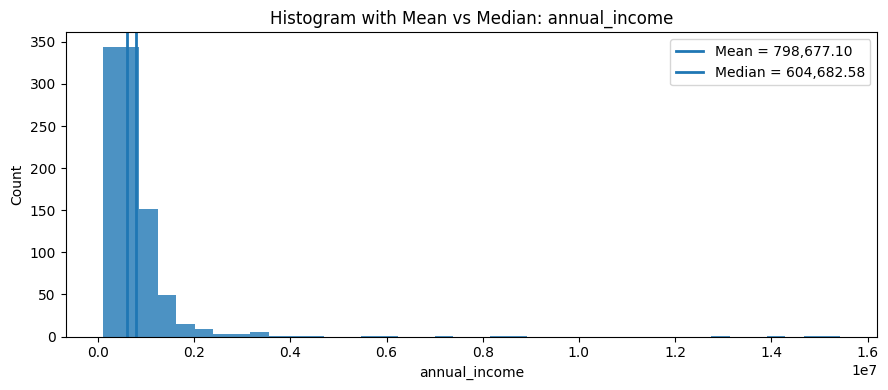

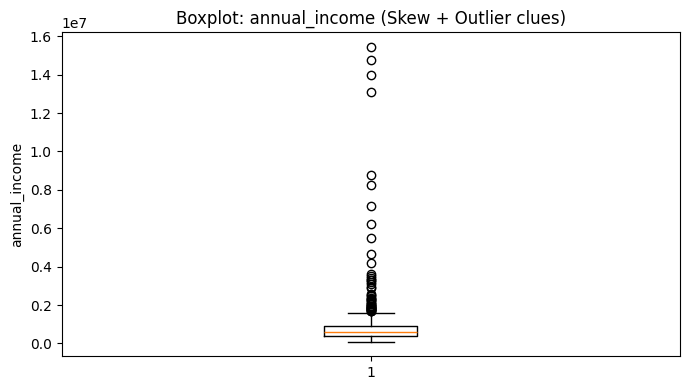

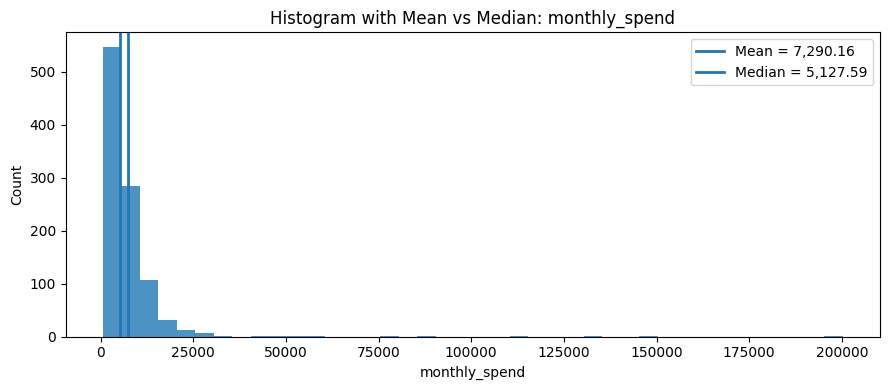

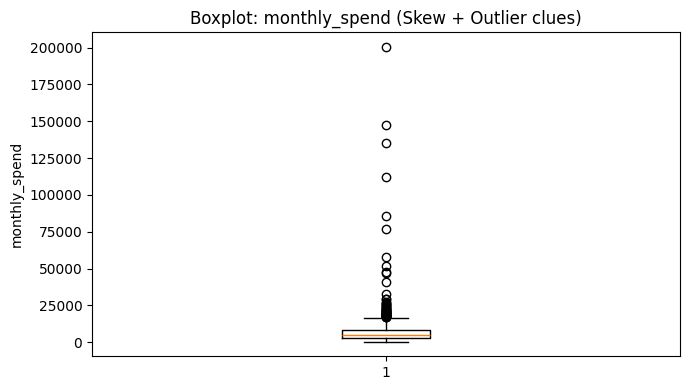

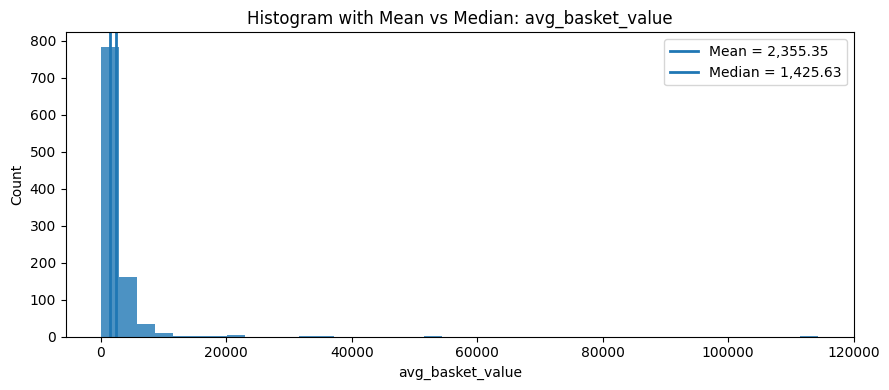

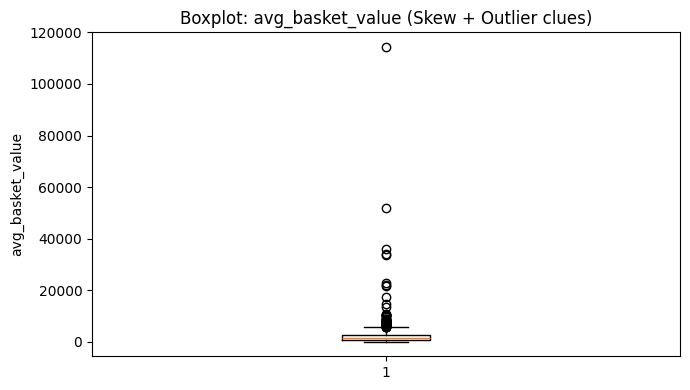

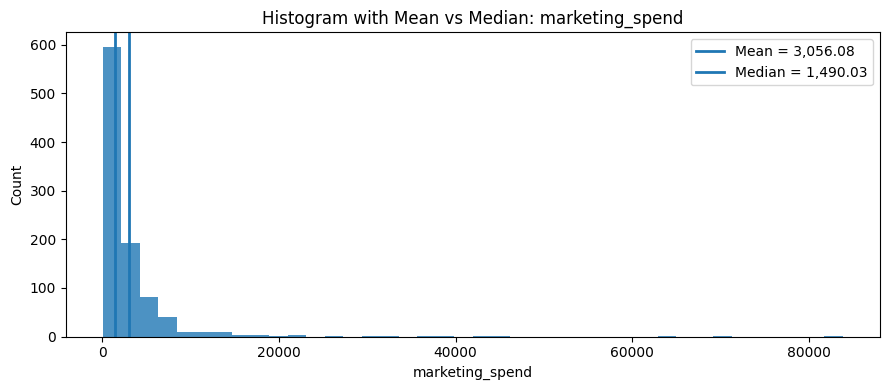

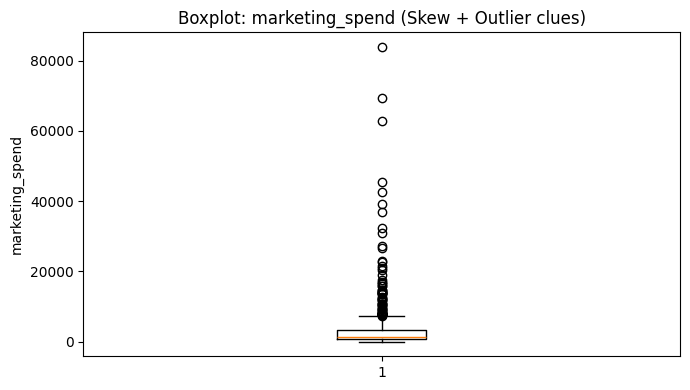

In [21]:
# 4) Skewness + Mean/Median diagnostics (Focus Columns)
# -----------------------------
print("\n--- Focus Column Diagnostics ---")
rows = []
for c in FOCUS_COLS:
    s = df_diag[c].dropna()
    sk = s.skew()
    mean_v = s.mean()
    med_v = s.median()
    rows.append([c, sk, mean_v, med_v, mean_v - med_v, interpret_skew(sk)])

diag_tbl = pd.DataFrame(rows, columns=["column", "skew", "mean", "median", "mean_minus_median", "interpretation"])
print(diag_tbl.round(3).to_string(index=False))

# Plots: histogram with mean/median + boxplot
for c in FOCUS_COLS:
    plot_hist_mean_median(df_diag[c], c)
    plot_box(df_diag[c], c)



In [22]:
# -----------------------------
# 5) Automated skewness audit across ALL numeric columns
# -----------------------------
numeric_cols = df_diag.select_dtypes(include=[np.number]).columns.tolist()
print("All numeric columns: \n",numeric_cols)

# Remove IDs and target from "transform candidates"
numeric_feature_cols = [c for c in numeric_cols if c not in ID_COLS + [TARGET_COL]]
print("All numeric columns after removal of ID and Target column: \n",numeric_feature_cols)

audit = []
for c in numeric_feature_cols:
    s = df_diag[c].dropna()
    if s.empty:
        continue
    sk = s.skew()
    miss_pct = df_diag[c].isna().mean() * 100
    min_v = s.min()
    has_nonpositive = (s <= 0).any()
    action = recommend_action(c, df_diag[c])
    audit.append([c, miss_pct, sk, min_v, has_nonpositive, interpret_skew(sk), action])

audit_df = pd.DataFrame(
    audit,
    columns=["column", "missing_%", "skew", "min_value", "has_nonpositive", "skew_interpretation", "recommended_action"]
).sort_values(by="skew", key=lambda x: x.abs(), ascending=False)

print("\n--- Skewness Audit (Top 15 by |skew|) ---")
print(audit_df.head(15).round(3).to_string(index=False))


All numeric columns: 
 ['customer_id', 'store_id', 'age', 'annual_income', 'monthly_spend', 'discount_percentage', 'purchase_frequency', 'avg_basket_value', 'avg_transaction_value', 'days_since_last_purchase', 'online_visits', 'total_returns', 'loyalty_score', 'marketing_spend', 'energy_consumption_store', 'target_sales']
All numeric columns after removal of ID and Target column: 
 ['age', 'annual_income', 'monthly_spend', 'discount_percentage', 'purchase_frequency', 'avg_basket_value', 'avg_transaction_value', 'days_since_last_purchase', 'online_visits', 'total_returns', 'loyalty_score', 'marketing_spend', 'energy_consumption_store']

--- Skewness Audit (Top 15 by |skew|) ---
                  column  missing_%   skew  min_value  has_nonpositive                          skew_interpretation                                         recommended_action
   avg_transaction_value        0.0 15.478     128.16            False severe skew (transform strongly recommended) Log1p or PowerTransform

In [24]:
# -----------------------------
# 6) Flag columns needing transformation (simple rule)
# -----------------------------
needs_transform = audit_df[abs(audit_df["skew"]) >= HIGH].copy()
optional_transform = audit_df[(abs(audit_df["skew"]) >= MILD) & (abs(audit_df["skew"]) < HIGH)].copy()

print("\nColumns strongly recommended for transform (|skew| >= 1.0):")
print(needs_transform["column"].tolist())

print("\nColumns optionally transform (0.5 <= |skew| < 1.0):")
print(optional_transform["column"].tolist())



Columns strongly recommended for transform (|skew| >= 1.0):
['avg_transaction_value', 'avg_basket_value', 'monthly_spend', 'total_returns', 'annual_income', 'marketing_spend', 'energy_consumption_store', 'days_since_last_purchase']

Columns optionally transform (0.5 <= |skew| < 1.0):
['discount_percentage', 'purchase_frequency', 'online_visits']


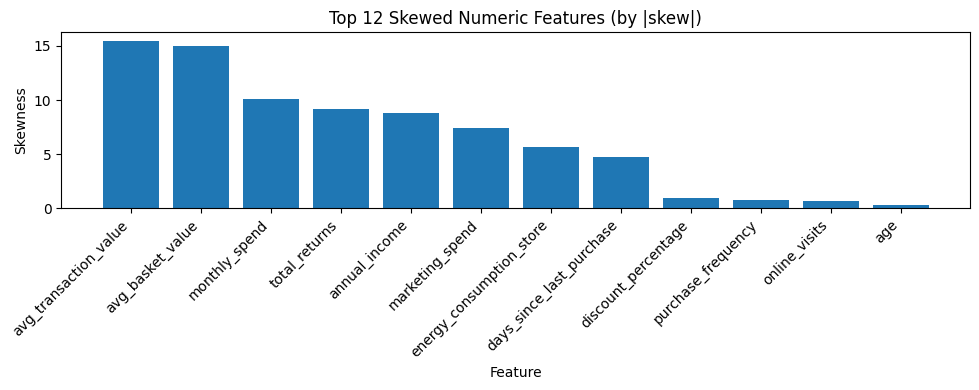

In [25]:
# -----------------------------
# 7) Quick multi-feature visualization: skews as a bar chart
# -----------------------------
plt.figure(figsize=(10, 4))
plt.bar(audit_df["column"].head(12), audit_df["skew"].head(12))
plt.title("Top 12 Skewed Numeric Features (by |skew|)")
plt.xlabel("Feature")
plt.ylabel("Skewness")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



In [26]:
# -----------------------------
# 8) show mean vs median gap ranking (another skew clue)
# -----------------------------
gap_df = audit_df.copy()
# compute mean-median gap safely
gaps = []
for c in audit_df["column"]:
    s = df_diag[c].dropna()
    gaps.append((s.mean() - s.median()))
gap_df["mean_minus_median"] = gaps
gap_df = gap_df.sort_values(by="mean_minus_median", ascending=False)

print("\n--- Top 10 features by Mean-Median Gap (right-skew clue) ---")
print(gap_df.head(10)[["column", "mean_minus_median", "skew", "recommended_action"]].round(3).to_string(index=False))

print("\nDone. Next step (Video 3) is applying log/power transforms based on these diagnostics.")



--- Top 10 features by Mean-Median Gap (right-skew clue) ---
                  column  mean_minus_median   skew                                         recommended_action
           annual_income         193994.521  8.780 Log1p or PowerTransform; consider RobustScaler if outliers
energy_consumption_store          21103.623  5.677 Log1p or PowerTransform; consider RobustScaler if outliers
           monthly_spend           2162.575 10.098 Log1p or PowerTransform; consider RobustScaler if outliers
         marketing_spend           1566.057  7.434 Log1p or PowerTransform; consider RobustScaler if outliers
   avg_transaction_value            942.883 15.478 Log1p or PowerTransform; consider RobustScaler if outliers
        avg_basket_value            929.712 14.950 Log1p or PowerTransform; consider RobustScaler if outliers
days_since_last_purchase              7.823  4.730     Use PowerTransform (Yeo-Johnson) or fix zeros then log
     discount_percentage              2.980  0.957        